# CNN 4 - Convolutions from scratch
- Dataset:
    - https://www.kaggle.com/shaunthesheep/microsoft-catsvsdogs-dataset
    
- Today we'll implement convolutions from scratch in pure Numpy
- A convolution boils down to repetitve matrix element-wise multiplication and summation, which should be easy to implement

In [1]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt

- Let's declare two functions for plotting images
- The first one plots a single image
- The second one plots two images side by side (1 row, 2 columns):

In [2]:
def plot_image(img: np.array):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap='gray');
    
def plot_two_images(img1: np.array, img2: np.array):
    _, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(img1, cmap='gray')
    ax[1].imshow(img2, cmap='gray');

- And now let's load in the image
    - We'll apply grayscaling and resizing to 224x224
    - Without grayscaling you'd have to apply convolution to each of the three color channels individually

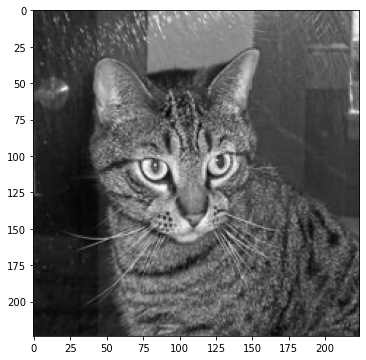

In [3]:
img = Image.open('data/train/cat/1.jpg')
img = ImageOps.grayscale(img)
img = img.resize(size=(224, 224))
plot_image(img=img)

<br>

## Declare filters for convolutions
- The task of a convolutional layer is to find N filters (kernels) that best extract features from the dataset
- Did you know there are known filters for doing various image operations?
    - We'll declare ones for sharpening, blurring, and outlining
    - Explore the rest here: https://setosa.io/ev/image-kernels/
- These are just 3x3 matrices:

In [4]:
sharpen = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

blur = np.array([
    [0.0625, 0.125, 0.0625],
    [0.125,  0.25,  0.125],
    [0.0625, 0.125, 0.0625]
])

outline = np.array([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

<br>

## Implement convolution from scratch
- We'll declare a helper function to make our lives easier
- It will calculate the target image size
- Sliding a 3x3 filter over an image means we'll lose a single pixel on all ends
    - You can address this with padding, but more on that later
    - For example, sliding a 3x3 filter over a 224x224 images results in a 222x222 image
    - Sliding a 5x5 filter over a 224x224 images results in a 220x220 image
- Let's write the function:

In [5]:
def calculate_target_size(img_size: int, kernel_size: int) -> int:
    num_pixels = 0
    
    # From 0 up to img size (if img size = 224, then up to 223)
    for i in range(img_size):
        # Add the kernel size (let's say 3) to the current i
        added = i + kernel_size
        # It must be lower than the image size
        if added <= img_size:
            # Increment if so
            num_pixels += 1
            
    return num_pixels

- Works as advertised:

In [6]:
calculate_target_size(img_size=224, kernel_size=3)

222

In [7]:
calculate_target_size(img_size=224, kernel_size=5)

220

<br>

Here's what convolution boils down to:
1. Let's extract the first 3x3 matrix from our image:

In [8]:
subset = np.array(img)[0:0+3, 0:0+3]
subset

array([[39, 41, 41],
       [42, 43, 44],
       [45, 44, 44]], dtype=uint8)

2. Do an element-wise multiplication between the image and the filter:

In [9]:
np.multiply(subset, sharpen)

array([[  0, -41,   0],
       [-42, 215, -44],
       [  0, -44,   0]])

3. Sum the elements in the matrix:

In [10]:
np.sum(np.multiply(subset, sharpen))

44

- And that's it!
- We can now apply this logic to the entire image
- The trickiest part is keeping track of the current N x N matrix
- You need to iterate over all rows and all columns in the image and than subset the image from there and apply the convolution:

In [11]:
def convolve(img: np.array, kernel: np.array) -> np.array:
    # Assuming a rectangular image
    tgt_size = calculate_target_size(
        img_size=img.shape[0],
        kernel_size=kernel.shape[0]
    )
    # To simplify things
    k = kernel.shape[0]
    
    # 2D array of zeros
    convolved_img = np.zeros(shape=(tgt_size, tgt_size))
    
    # Iterate over the rows
    for i in range(tgt_size):
        # Iterate over the columns
        for j in range(tgt_size):
            # img[i, j] = individual pixel value
            # Get the current matrix
            mat = img[i:i+k, j:j+k]
            
            # Apply the convolution - element-wise multiplication and summation of the result
            # Store the result to i-th row and j-th column of our convolved_img array
            convolved_img[i, j] = np.sum(np.multiply(mat, kernel))
            
    return convolved_img

- Let's test it
- Sharpening filter first:

In [13]:
# Let us apply the function written above to our image and also apply filter/kernel=sharpen
# Converting our image to numpy array and applying the kernel=sharpen (we use the function written above - which
# perform complete convolutional operation on our single image

img_sharpened = convolve(img=np.array(img), kernel=sharpen)

- Here's how the image looks like in matrix format:

In [14]:
img_sharpened

array([[ 44.,  48.,  49., ..., 176., 235., 200.],
       [ 46.,  49.,  45., ..., 179., 219., 191.],
       [ 43.,  38.,  37., ..., 177., 210., 200.],
       ...,
       [ 22.,  19.,  14., ...,  20.,  81.,   2.],
       [ 28.,  17.,  14., ...,  23.,  23.,   1.],
       [ 32.,  22.,  18., ..., -23.,  29.,  -1.]])

- Let/s visualize it:

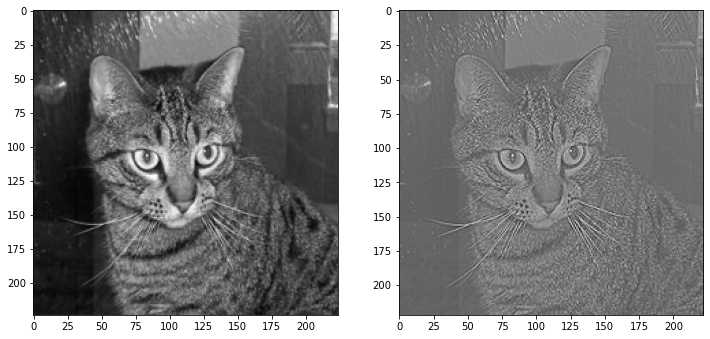

In [15]:
# Let us use our function we wrote at the beginning of this tutorial to display the original and sharpened images.
plot_two_images(
    img1=img, 
    img2=img_sharpened
)

- The colors are a bit off since values in the matrix don't range between 0 and 255
- It's not a problem, but we can "fix" it by replacing all negative values with zeros:

In [16]:
# - The colors are a bit off since values in the matrix don't range between 0 and 255
# - It's not a problem, but we can "fix" it by replacing all negative values with zeros:
# - Let us write a function for performing the operation.

def negative_to_zero(img: np.array) -> np.array:
    img = img.copy()
    img[img < 0] = 0
    return img

- And plot it again:

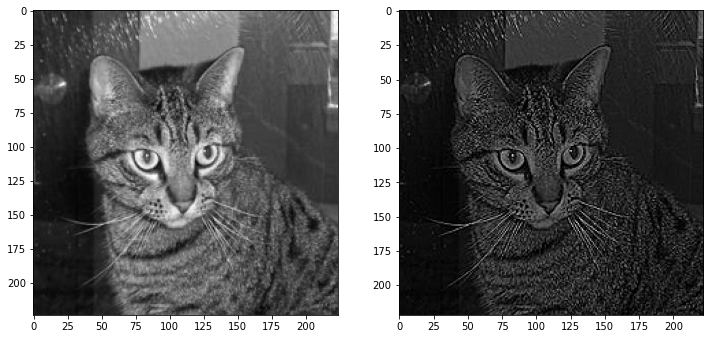

In [17]:
plot_two_images(
    img1=img, 
    img2=negative_to_zero(img=img_sharpened)
)

- You can see that the image definitely looks sharper, no arguing there
- Let's blur the image next:

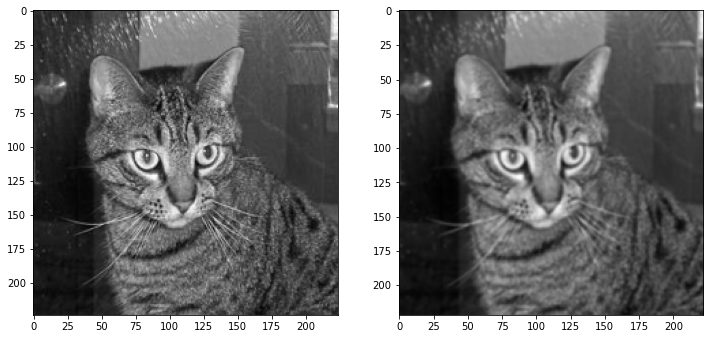

In [19]:
# Next, let us apply kernel=blur to our image and use our plot two-image function.

img_blurred = convolve(img=np.array(img), kernel=blur)
plot_two_images(
    img1=img, 
    img2=img_blurred
)

- The blurring filter matrix doesn't have negative values, so the coloring is identical
- You can clearly see how the image was blurred
- Finally, let's apply the outline:

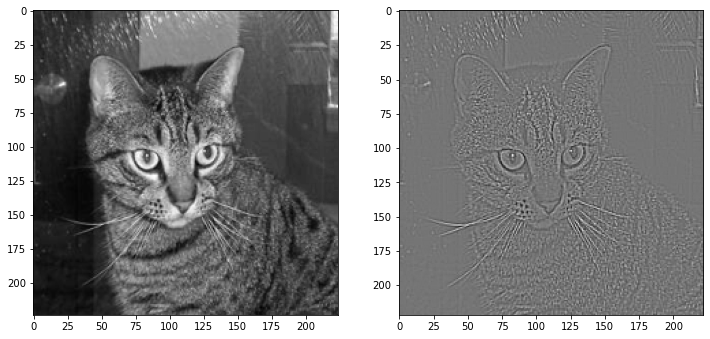

In [21]:
# Next, let us apply kernel/filter=outline to our image and use our plot two-image function.

img_outlined = convolve(img=np.array(img), kernel=outline)
plot_two_images(
    img1=img, 
    img2=img_outlined
)

- It suffers from the same coloring problem: -ve pixels are present. Let apply -ve to zero function we applied before

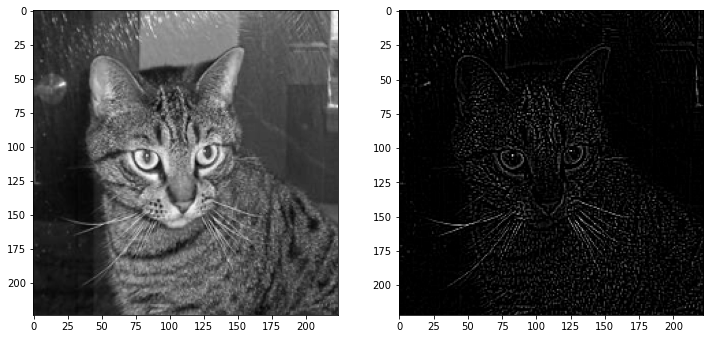

In [22]:
plot_two_images(
    img1=img, 
    img2=negative_to_zero(img=img_outlined)
)

- Amazing!
- All convolved images are of shape 222x222
- What if you want to keep the original size of 224x224?
- That's where padding comes into play

<br><br>

## Implement convolutions with padding from scratch
- TensorFlow's `Conv2D` layer lets you specify either `valid` or `same` for the `padding` parameter
- The first one is default, which means no padding is added to the images (what we implemented above)
- The second one will add padding depending on the kernel size, so the source and convolved images are of the same shape
- Padding is essentially just a "black" border around the image
    - It's black because typically zeros are added, and zeros represent the color black
    - The black borders don't have an impact on the calculations, since they're zero, and a convolution operation multiplies elements of an image with the elements of a filter. Anything multiplied with a zero is a zero
- First, let's declare a helper function that calculates how "thick" of a border we need to add to the image
    - The bigger the kernel size, the thicker the border
    - All sides of the image will have the exact same border
    - It's just an integer division:

In [23]:
def get_padding_width_per_side(kernel_size: int) -> int:
    # Simple integer division
    return kernel_size // 2

- For example, 3x3 kernel means 3 // 2 which is 1
- Add 1 pixel to each side:

In [24]:
pad_3x3 = get_padding_width_per_side(kernel_size=3)
pad_3x3

1

- 5 // 2 = 2:

In [25]:
pad_5x5 = get_padding_width_per_side(kernel_size=5)
pad_5x5

2

- Let's declare yet another helper function
- It's task is to add a padding to the image
- First, the function declares a matrix of zeros with a shape of (image.shape + padding * 2)
    - We multiply the padding with 2 because we need it on all sides
- Then we index the matrix so the padding is ignored and change the zeros with the actual image values:

In [26]:
def add_padding_to_image(img: np.array, padding_width: int) -> np.array:
    # Array of zeros of shape (img + padding_width)
    img_with_padding = np.zeros(shape=(
        img.shape[0] + padding_width * 2,  # Multiply with two because we need padding on all sides
        img.shape[1] + padding_width * 2
    ))
    
    # Change the inner elements
    # For example, if img.shape = (224, 224), and img_with_padding.shape = (226, 226)
    # keep the pixel wide padding on all sides, but change the other values to be the same as img
    img_with_padding[padding_width:-padding_width, padding_width:-padding_width] = img
    
    return img_with_padding

- Let's test it by adding a padding to the image for 3x3 filter:

(226, 226)


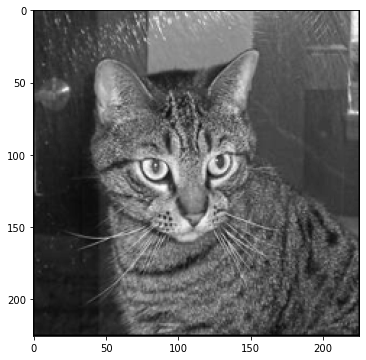

In [27]:
img_with_padding_3x3 = add_padding_to_image(
    img=np.array(img), 
    padding_width=pad_3x3
)

print(img_with_padding_3x3.shape)
plot_image(img_with_padding_3x3)

- It adds a 1 pixel-wide border to the image and makes it 226x226 in size
- Here's how the matrix looks like:

In [28]:
img_with_padding_3x3

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,  39.,  41., ..., 195., 197.,   0.],
       [  0.,  42.,  43., ..., 197., 195.,   0.],
       ...,
       [  0.,  32.,  28., ...,  29.,  49.,   0.],
       [  0.,  30.,  27., ...,  38.,  32.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

- You can see the original image surrounded with zeros - that's just what we wanted
- Let's see if the same is true for the 5x5 kernel:

(228, 228)


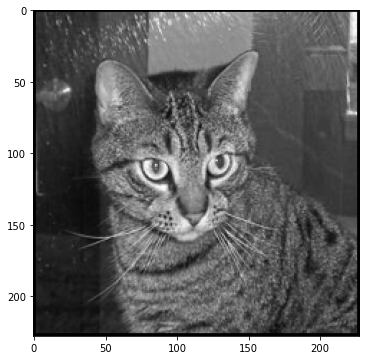

In [29]:
img_with_padding_5x5 = add_padding_to_image(
    img=np.array(img), 
    padding_width=pad_5x5
)

print(img_with_padding_5x5.shape)
plot_image(img_with_padding_5x5)

- You can now visually see the black border, but still let's verify it's there:

In [30]:
img_with_padding_5x5

array([[  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,  39., ..., 197.,   0.,   0.],
       ...,
       [  0.,   0.,  30., ...,  32.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   0.]])

- Everything looks good
- Let's apply a convolution operation to our 226x226 image (1 pixel-wide border):

In [31]:
img_padded_3x3_sharpened = convolve(img=img_with_padding_3x3, kernel=sharpen)
img_padded_3x3_sharpened.shape

(224, 224)

- The result is an 224x224 image, which is the same as the original one!
- Let's plot them side by side to verify:

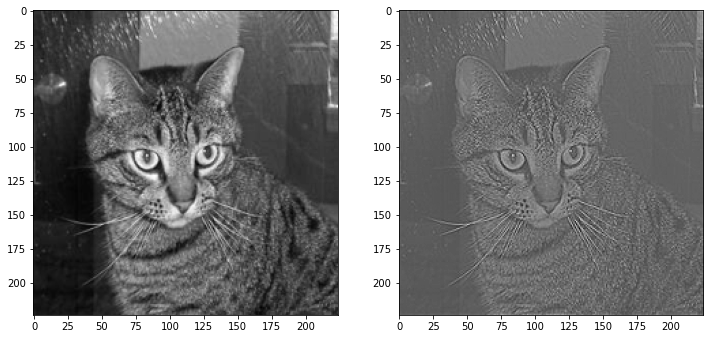

In [43]:
plot_two_images(
    img1=img, 
    img2=img_padded_3x3_sharpened
)

- And that's how convolutions and padding work
- TensorFlow's Conv2D layer is here to find the optimal filter matrices, but once it does, this is essentially what happens.
- The next notebook will cover pooling from scratch, so stay tuned.